# Walmart : predict weekly sales

This is a project for [JEDHA](https://www.jedha.co/) Data Science Full-Stack Bootcamp.

## Project 🚧
Walmart's marketing service has asked you to build a machine learning model able to estimate the weekly sales in their stores, with the best precision possible on the predictions made. Such a model would help them understand better how the sales are influenced by economic indicators, and might be used to plan future marketing campaigns.

## Goals 🎯
The project can be divided into three steps:

- Part 1 : make an EDA and all the necessary preprocessings to prepare data for machine learning
- Part 2 : train a linear regression model (baseline)
- Part 3 : avoid overfitting by training a regularized regression model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

%matplotlib inline

In [2]:
data = pd.read_csv("Walmart_Store_sales.csv")
data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


# PART 1

## EDA

In [3]:
print("Number of Observations:", data.shape[0])
data.shape[0]

Number of Observations: 150


150

In [4]:
#let's immediately drop all observations where the target variable missing
data.dropna(subset=['Weekly_Sales'], inplace =True)
len(data)

136

In [5]:
print("Percentage of missing values in each column: % ")
display(100*data.isnull().sum()/data.shape[0])

Percentage of missing values in each column: % 


Store            0.000000
Date            13.235294
Weekly_Sales     0.000000
Holiday_Flag     8.088235
Temperature     11.029412
Fuel_Price       8.823529
CPI              8.088235
Unemployment    10.294118
dtype: float64

In [6]:
df = data.copy() 
df['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

### Variable Distributions
- Categorical variables: Store, Holiday_Flag
- Numerical variables : Temperature, Fuel_Price, CPI, Unemployment, Year, Month, Day

In [7]:
target = 'Weekly_Sales'
features_list = [item for item in df.columns if item not in target]

cat_features = ['Store', 'Holiday_Flag']
num_features = ['Temperature','Fuel_Price', 'CPI','Unemployment']

In [8]:
sns.set_theme()

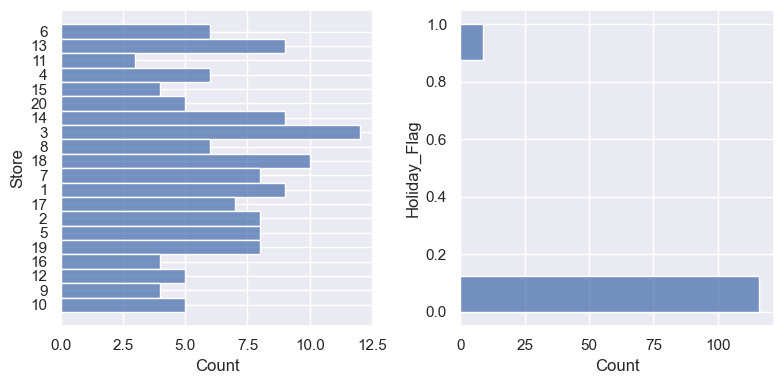

In [9]:
df["Store"] = df["Store"].astype(int).astype(str)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # Creating subplots with 1 row and 2 columns
axes = axes.flatten()

for i, column in enumerate(cat_features):
    sns.histplot(y=column, data=df, ax=axes[i], stat="count")  # Using sns.histplot instead of sns.displot

# Adjust layout
plt.tight_layout()
plt.show()

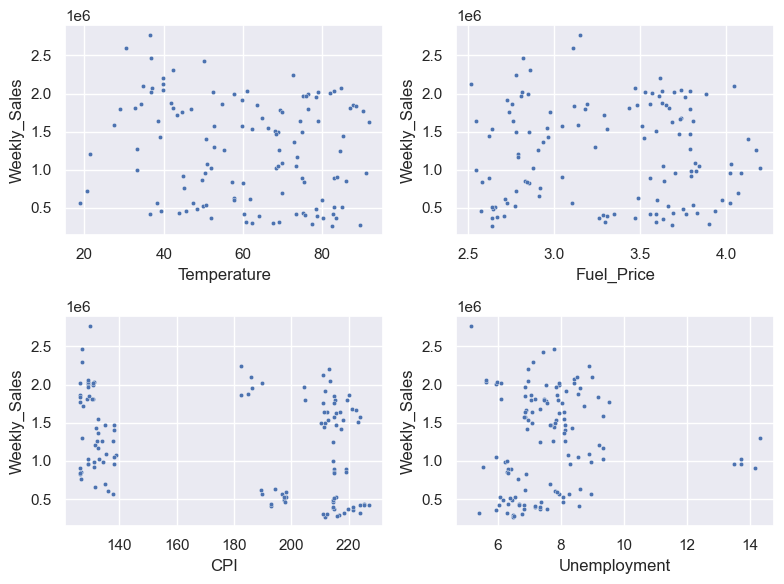

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

axes = axes.flatten()

for i, column in enumerate(num_features):
    sns.scatterplot(x=column, y=target, data=df, s=10, ax=axes[i])



# Adjust layout
plt.tight_layout()
plt.show()

Looking at this scatter plot, it is hard to see a strong relationship between the weekly sales and the numerical variables in the dataset. However, we may observe that it has a mild negative correlation with CPI and with temperature. We can also create a correlation matrix, which will support this observation.

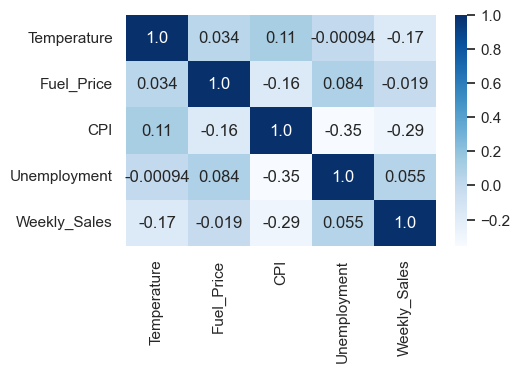

<Figure size 640x480 with 0 Axes>

In [11]:
correlation_matrix = df[num_features + [target]].corr()
plt.figure(figsize=(5,3))
sns.heatmap(correlation_matrix, cbar=True, fmt='.2', annot=True, cmap='Blues')
plt.show()
plt.savefig('Correlation Heat map')


#### Therefore, it might be useful to look at categorical and time variables to predict weekly sales.
- First, let's break the "Date" variable into Day, Month and Year columns.
- This variable will also be particularly useful for the missing value imputation rather than the prediction.

Since the target variable is weekly sales anyway, in other words aggregation of an entire week, I do not find the creation of a "day of the week" variable necessary. 

In [12]:
df[['Day', 'Month', 'Year']] = df['Date'].dt.strftime('%d %m %Y').str.split(expand=True)
df[['Day', 'Month', 'Year']] = df[['Day', 'Month', 'Year']].astype('Int64', errors='ignore')

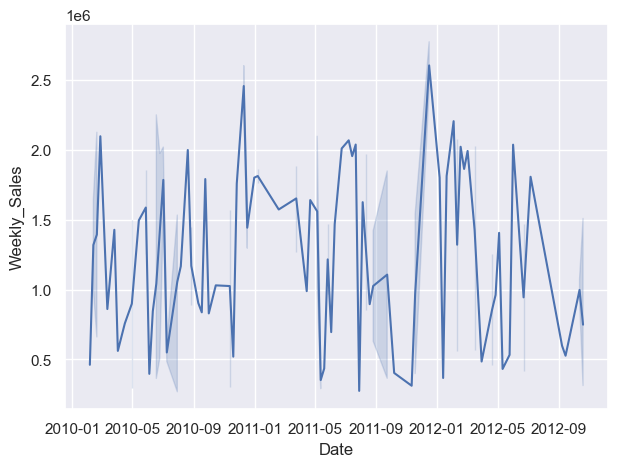

In [13]:
plt.figure(figsize=(7,5))
sns.lineplot(data=df,x='Date',y='Weekly_Sales',palette='tab10')
plt.show()

Initially weekly sales did not follow a linear pattern over time, however this graph with ups and downs actually implies the possibility of a rather seasonal pattern. Let's check that out:

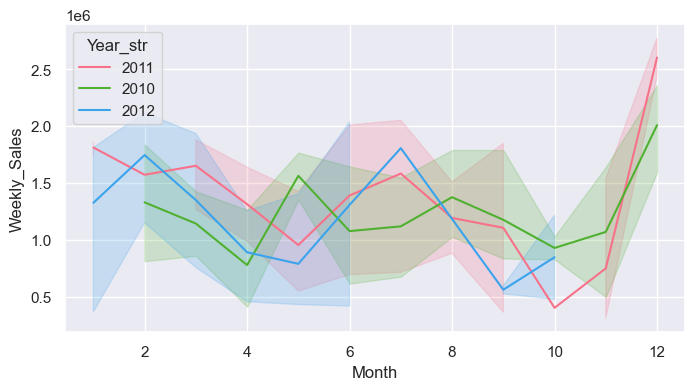

In [306]:
df['Year_str'] = df['Year'].astype(str)
plt.figure(figsize=(8,4))
sns.lineplot(data=df[df['Date'].isna()==False],x='Month',y='Weekly_Sales',hue='Year_str',palette="husl")
plt.show()

There seems indeed to be a seasonal pattern in the weekly sales with February-April showing a declining tend and december showing an annual peak.

Let's now check how categorical variables interact with weekly sales.

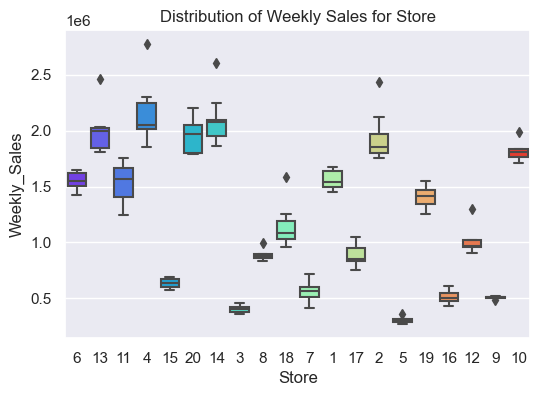

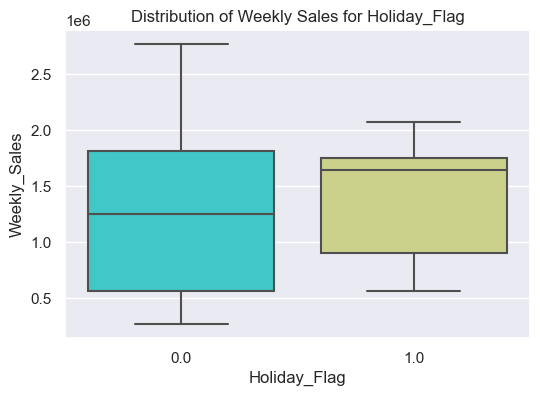

In [14]:
for var in cat_features:
    plt.figure(figsize=(6, 4))  # Set figure size
    plot = sns.boxplot(data=df, x=var, y='Weekly_Sales',palette='rainbow')
    plot.set_title(f'Distribution of Weekly Sales for {var}') 

plt.show()

- By looking at the first graph, we could see that the store ID is a good predictor of the average weekly sales as their sale averages range from less than half a million to more than 2 million USD.
- Also, while the revenue from weekly sales might show significant variation for some stores (such as 11), there are other stores where the weekly sales revenue show very little variation (like store_9)

- As expected, holiday periods have a higher average of weekly sales, and lower variance.

## Data Preprocessing 

The stores belonging to different regions, this can affect the temperature, prices, or unemployment race. 

Therefore, instead of using the SimpleImputer class from sklearn, I will designate custom imputers for each variable using store ID as a proxy of the region where the branch is located:
- for missing values of temperature, I will be using the average temperature of the same month from other years in the region of that store
- for missing values of fuel_price, CPI and unemployment, I will be using the yearly averages for each store location
- since the data covers the National Holidays, for missing values of Holiday_Flag I will check the other observations from the same date, and if these ones possesses the Holiday_Flag information, I will retrieve it from there.

In [15]:
num_annual_means = ['Fuel_Price', 'CPI','Unemployment'] 
num_seasonal_means = ['Temperature']
cat_by_date = ['Holiday_Flag']
cat_features += ['Year', 'Month']
features_list = cat_features + num_features

In [16]:
df_train, df_test = train_test_split(df, test_size = 0.25, random_state = 0)

## Attention:
- Whether to implement train_test_split before or after the missing value imputation is a decision up to the project team most of the time.
- Implementing the split before imputation and preprocessing have advantages like minimizing information leakage from test set to train set and hence mimic better the real life scenarios where the model would be expected to perform on a set it hadn't seen neither in the imputation nor in preprocessing stage.
- Yet, in the cases like this project where the training data is very limited, there is a high chance that the model will encounter some values or categories in the test set that it hasn't seen in the training set, therefore, the fit_transform and transform methods of imputer and preprocessing pipelines are likely to raise an error.
- For example, here I performed the train_test_split before the imputation and preprocessing and verified that such an error would not occur by setting the seed to 0, however, feel free to change the seed (for example 42) by modifying random_state and you will see how the model will encounter some store IDs that were not in the training set in imputer.transform(df_test).
- In the Bonus section when performing the GridSearch, I will go for the other option, make the imputation before split and then test the robustness of the model by several random splits. 

In [17]:
class CustomImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        
        #if we're dealing with numeric data:
        for var in num_features :
            #first, drop outliers so that they won't affect our mean imputations
            lower_bound = X[var].mean(skipna = True) - 3 * X[var].std(skipna = True)
            upper_bound = X[var].mean(skipna = True) + 3 * X[var].std(skipna = True)
            
            mask = (X[var].isna()) | ((X[var] > lower_bound) & (X[var] < upper_bound))
            X = X[mask].reset_index(drop=True)
        
        #now we can impute means
        for var in num_annual_means:
            #annual averages of that location for the variables ['Fuel_Price', 'CPI','Unemployment'] 
            X[var] = X[var].fillna(X.groupby(['Store', 'Year'])[var].transform('mean'))
            
        for var in num_seasonal_means: 
            #seasonal (monthly) averages of that location for 'Temperature'
            X[var] = X[var].fillna(X.groupby(['Store','Month'])[var].transform('mean'))
            

        #if we're dealing with ('Holiday_Flag')
        for var in cat_by_date: 
            X[var] = X[var].fillna(X.groupby('Date')[var].transform('mean')).astype(int, errors='ignore')
        
        #drop the values we couldn't impute
        X = X.dropna()
        
        #make sure month and year are strings:
        for var in ['Year', 'Month']:
            X[var] = X[var].astype(int).astype(str)
        
        
        return X
    

In [18]:
imputer = Pipeline(
    steps=[
        ("custom_imputer", CustomImputer())
    ]
)

imputed_train = imputer.fit_transform(df_train)
imputed_test = imputer.transform(df_test)


In [19]:
num_transformer = Pipeline(steps =[
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('encoder', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features) #actually Holiday_Flag is already one-hot encoded but it's ok
    ])

In [20]:
X_train, X_test, Y_train, Y_test = imputed_train[features_list], imputed_test[features_list], imputed_train[target], imputed_test[target]

In [21]:
X_train

,Store,Holiday_Flag,Year,Month,Temperature,Fuel_Price,CPI,Unemployment
0,14,1.0,2012,2,37.00,3.695,189.842483,8.424
1,3,0.0,2012,6,82.70,3.346,225.306861,6.664
2,7,1.0,2012,9,57.84,3.596,198.095048,7.872
3,11,1.0,2010,11,69.90,2.735,215.061403,7.564
4,19,0.0,2010,7,66.25,2.958,132.521867,8.099
...,...,...,...,...,...,...,...,...
91,19,0.0,2010,3,39.07,2.963,131.863129,8.350
92,8,0.0,2011,8,82.92,3.554,219.070197,6.425
94,1,0.0,2010,8,85.22,2.619,211.567306,7.787
95,13,0.0,2011,8,75.95,3.606,129.201581,6.877


In [22]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [23]:
X_train.shape

(73, 36)

# PART 2 : BASELINE MODEL

In [24]:
regressor = LinearRegression() 
regressor.fit(X_train, Y_train)

LinearRegression()

In [25]:
Y_train_pred = regressor.predict(X_train)
Y_test_pred = regressor.predict(X_test)

In [26]:
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

R2 score on training set :  0.991963826446867
R2 score on test set :  0.8624819379111521


In [27]:
preprocessor.transformers_

[('num',
  Pipeline(steps=[('scaler', StandardScaler())]),
  ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']),
 ('cat',
  Pipeline(steps=[('encoder', OneHotEncoder(drop='first'))]),
  ['Store', 'Holiday_Flag', 'Year', 'Month'])]

In [28]:
column_names = []
for name, transformer, features in preprocessor.transformers_:
    if name == 'num': 
        features = features 
    elif name == 'cat': # if pipeline is for categorical variables
        # get output columns names from OneHotEncoder
        features = transformer.named_steps['encoder'].get_feature_names_out() 
    column_names.extend(features)
        

In [29]:
coefs = pd.DataFrame(index = column_names, data = regressor.coef_.transpose(), columns=["coefficients"])
pd.options.display.float_format = '{:.2f}'.format
coefs

,coefficients
Temperature,60192.18
Fuel_Price,-62641.93
CPI,521477.47
Unemployment,-125372.74
Store_10,1731651.99
Store_11,85646.60
Store_13,1542575.43
Store_14,1050952.29
Store_15,318335.78
Store_16,-792770.79


Text(0.5, 1.0, 'Feature Importance')

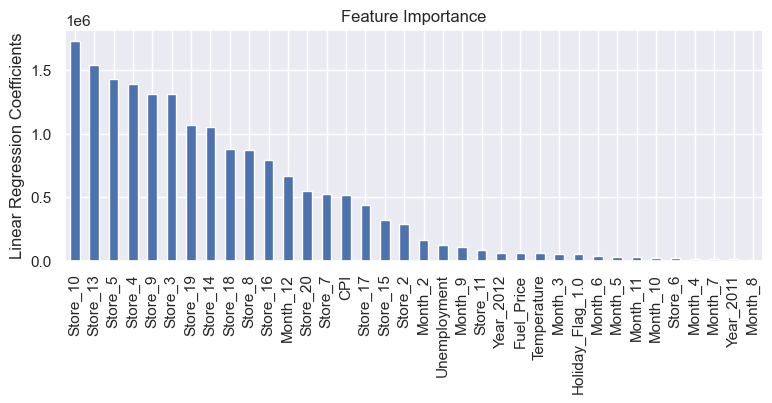

In [30]:
importance = pd.Series(np.abs(regressor.coef_.ravel()))
importance.index = column_names
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(9,3))
plt.ylabel('Linear Regression Coefficients')
plt.title('Feature Importance')

Looking at the Feature Importance (Absolute Values of Coefficients):
- we can infer that store ID is quite a predictive indicator of the weekly sales, on the other hand, variables like fuel price or temperature does not seem to explain much of the variation in sales.
- as we realized during EDA, the month december is indeed a strong predictor of higher weekly sales (absolute value can be seen in the graph and the sign of the effect could be seen in the table above).



# PART 3: REGULARIZATION

While the R2 is 0.99 for the train set, it is around 0.86 for the test set, therefore we have a good reason to suspect that there might be overfitting in our model.

Let's try to overcome this with regularization.

### Lasso Regularization

In [31]:
from sklearn.linear_model import Lasso

In [32]:
lasso = Lasso(max_iter = 20000, random_state=42) #the number of iterations is chosen by trial-error till ensure convergence
lasso.fit(X_train, Y_train)

Y_train_pred = lasso.predict(X_train)
Y_test_pred = lasso.predict(X_test)

print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

R2 score on training set :  0.9919627570541822
R2 score on test set :  0.8626556972809494


Here, Lasso regularization with the default hyperparameters performed quite similarly to our baseline model without regularization.
Let's check if the feature importances have changed.

Text(0.5, 1.0, 'Feature Importance')

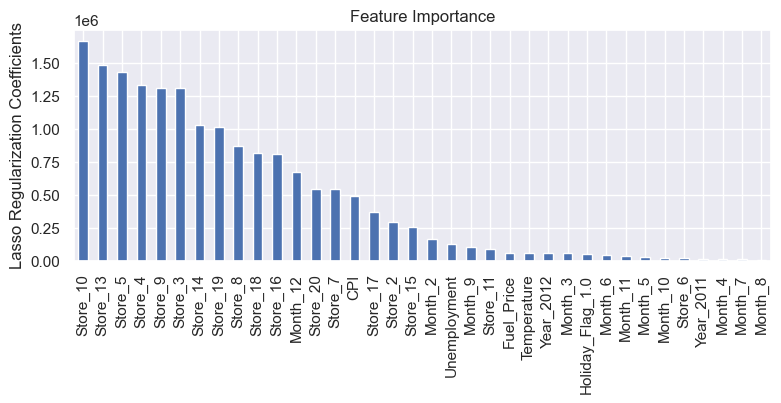

In [33]:
importance = pd.Series(np.abs(lasso.coef_.ravel()))
importance.index = column_names
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(9,3))
plt.ylabel('Lasso Regularization Coefficients')
plt.title('Feature Importance')

Both the values and the respective importances of the coefficients did not change much

### Ridge Regularization

In [34]:
from sklearn.linear_model import Ridge

In [35]:
ridge = Ridge(random_state = 42)
ridge.fit(X_train, Y_train)

Y_train_pred = ridge.predict(X_train)
Y_test_pred = ridge.predict(X_test)

print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

R2 score on training set :  0.939986891642339
R2 score on test set :  0.9257309604201062


Even with the default hyperparameters, Ridge Regularization seems to have accomplished a better job in dealing with the overfitting and achieved a much better R2 score than the two previous models!

Text(0.5, 1.0, 'Feature Importance')

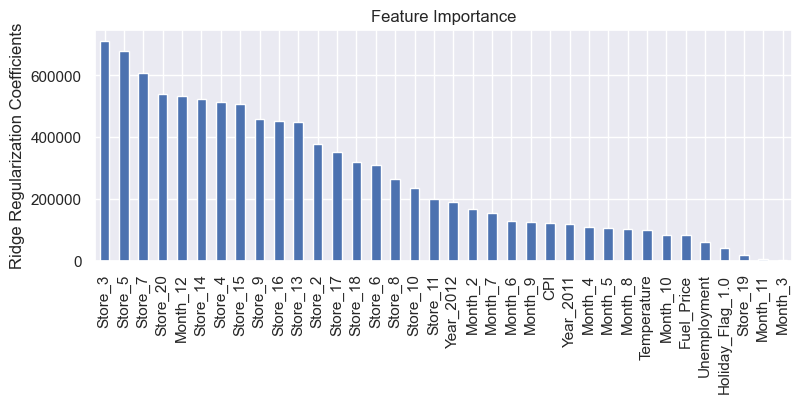

In [36]:
importance = pd.Series(np.abs(ridge.coef_.ravel()))
importance.index = column_names
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(9,3))
plt.ylabel('Ridge Regularization Coefficients')
plt.title('Feature Importance')

- In a first glance, we can see that all coefficients decreased significantly in terms of the magnitude. (from 7-digit values to 6-digits)
- While Store ID keep being an important predictor, now the month december seems to become even more important.

I obtained three models after finding optimum values of alpha for Lasso model and Ridge model through GridSearchCV.
Let's print out the optimum alpha values that achieved the highest R2 on the train sets for each of the regularized models:

## Bonus : GridSearch

In [37]:
#alpha values to try for grid search
lasso_params = {'alpha':[0.001, 0.01, 0.1, 1, 10]}
ridge_params = {'alpha':[0.001, 0.01, 0.1, 1, 10]}

models = {'OLS': LinearRegression(),
           'Lasso': GridSearchCV(Lasso(max_iter = 10000000), param_grid=lasso_params, cv = 10).fit(X_train, Y_train).best_estimator_,
           #Lasso model requires a lot iteration to converge
          'Ridge': GridSearchCV(Ridge(), param_grid=ridge_params, cv = 10).fit(X_train, Y_train).best_estimator_}



In [38]:
models['Lasso']

Lasso(alpha=10, max_iter=10000000)

In [39]:
models['Ridge']

Ridge(alpha=1)

Finally let's see which of these optimized models will perform better on the test set.

### Attention:
- As I mentioned before creating my custom imputer class, imputation after train_test_split might result in missing categories for the one_hot encoding of the categorical variable and hence make it harder to test the robustness of the model's results.
- Below, I will compare three models (Linear, Lasso, and Ridge) by checking their performances on train and test set in different random splits and averaging their R2 scores.
- Therefore, to avoid problems with imputer pipeline, I will first impute the missing variables, then split the data into train and test sets.

In [40]:
def compare_models(models, data , iterations = 100):
    results = {}
    for i in models:
        r2_train = []
        r2_test = []
        for j in range(iterations):
            data = imputer.fit_transform(data)
            ### here I performed imputation before split
            data_train, data_test = train_test_split(data, test_size = 0.25) 
           
            
            Xtrain, Xtest, Ytrain, Ytest = imputed_train[features_list],imputed_test[features_list], imputed_train[target], imputed_test[target]
            Xtrain = preprocessor.fit_transform(Xtrain)
            Xtest = preprocessor.transform(Xtest)
            
                                                               
            r2_test.append(r2_score(Ytest,
                                            models[i].fit(Xtrain, 
                                                         Ytrain).predict(Xtest)))
            r2_train.append(r2_score(Ytrain, 
                                             models[i].fit(Xtrain, 
                                                          Ytrain).predict(Xtrain)))
        results[i] = [np.mean(r2_train), np.mean(r2_test)]
        result_df = pd.DataFrame(results)
        result_df.index = ['train', 'test']
    
    return result_df
  


In [41]:
compare_models(models, df)

,OLS,Lasso,Ridge
train,0.99,0.99,0.94
test,0.86,0.86,0.93


Even after the hyperparameter optimization, Ridge model significantly outperforms the other two. 